In [166]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim

# Use a double ended queue (deque) for memory
# When memory is full, this will replace the oldest value with the new one
from collections import deque
import torch.nn.functional as F
from Patient_Flow import *
# Supress all warnings (e.g. deprecation warnings) for regular use
import warnings
warnings.filterwarnings("ignore")

In [167]:
################################################################################
#                           2 Define model parameters                          #
################################################################################

# Set whether to display on screen (slows model)
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.95
# Learing rate for neural network
LEARNING_RATE = 0.00001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 1000000
# Sample batch size for policy network update
BATCH_SIZE = 10
# Number of game steps to play before starting training (all random actions)
REPLAY_START_SIZE =  4
# Time step between actions
TIME_STEP = 120
# Number of steps between policy -> target network update
SYNC_TARGET_STEPS = 500
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0
# Simulation duration
SIM_DURATION = 24*60
# Training episodes
TRAINING_EPISODES = 2

In [168]:
################################################################################
#                      3 Define DQN (Deep Q Network) class                     #
#                    (Used for both policy and target nets)                    #
################################################################################

class DQN(nn.Module):

    """Deep Q Network. Udes for both policy (action) and target (Q) networks."""

    def __init__(self, observation_space, action_space, neurons_per_layer=48, threshold = 0.3):
        """Constructor method. Set up neural nets."""

        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        self.threshold = threshold
        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, action_space)
            )
        self.net1 = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, action_space)
            )
        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            with torch.no_grad():
                # Otherwise get predicted Q values of actions
                q_values = self.net(torch.FloatTensor(state))
                i = self.net1(torch.FloatTensor(state))
                imt = F.log_softmax(i, dim=1)
                imt = imt.exp()
                imt = (imt/imt.max(1, keepdim=True)[0] > self.threshold).float()
                # Use large negative number to mask actions from argmax
                action = int((imt * q_values + (1. - imt) * -1e8).argmax(1))
        
        return  action
        
        
    def forward(self, x):
        """Forward pass through network"""
        i = self.net1(x)
        return self.net(x),F.log_softmax(i, dim=1), i

In [169]:
################################################################################
#                    4 Define policy net training function                     #
################################################################################

def optimize(policy_net, target_net, memory, threshold = 0.3):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate (exploration rate is stored in policy net)
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    #print(policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = random.sample(memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
        
        with torch.no_grad():
            # Get target Q for policy net update

            if not terminal:
                # For non-terminal actions get Q from policy net
                expected_state_action_values, imt, i = policy_net(torch.FloatTensor(state))
                # Detach next state values from gradients to prevent updates
                expected_state_action_values = expected_state_action_values.detach()
                # Get next state action with best Q from the policy net (double DQN)
                policy_next_state_values, next_imt, next_i = policy_net(torch.FloatTensor(state_next))
                policy_next_state_values = policy_next_state_values.detach()
                next_imt = next_imt.exp()
                next_imt = (next_imt/next_imt.max(1, keepdim=True)[0] > threshold).float()
                next_action = (next_imt * policy_next_state_values + (1 - next_imt) * -1e8).argmax(1, keepdim=True)
                # Get target net next state
                next_state_action_values,_,_ = target_net(torch.FloatTensor(state_next))
                # Use detach again to prevent target net gradients being updated
                next_state_action_values = next_state_action_values.detach()
                best_next_q = next_state_action_values[0][next_action]
                updated_q = reward + (GAMMA * best_next_q)      
                expected_state_action_values[0][action] = updated_q
            else:
                # For termal actions Q = reward (-1)
                expected_state_action_values,imt,i = policy_net(torch.FloatTensor(state))
                # Detach values from gradients to prevent gradient update
                expected_state_action_values = expected_state_action_values.detach()
                # Set Q for all actions to reward (-1)
                expected_state_action_values[0] = reward
            
        state_action_values, imt ,i = policy_net(torch.FloatTensor(state))
        # Set net to training mode
        policy_net.train() 
        
        q_loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        i_loss = F.nll_loss(imt, torch.tensor([action]))
        Q_loss = q_loss + i_loss + 1e-2 * i.pow(2).mean()
        
        # Reset net gradients
        policy_net.optimizer.zero_grad() 
        # Backpropogate loss
        Q_loss.backward()
        # Update network gradients
        policy_net.optimizer.step()  

    return

In [170]:
################################################################################
#                            5 Define memory class                             #
################################################################################

class Memory():
    """
    Replay memory used to train model.
    Limited length memory (using deque, double ended queue from collections).
      - When memory full deque replaces oldest data with newest.
    Holds, state, action, reward, next state, and episode done.
    """
    
    def __init__(self):
        """Constructor method to initialise replay memory"""
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        self.memory.append((state, action, reward, next_state, done))

In [171]:
################################################################################
#                       6  Define results plotting function 
# neen to work on this bit
################################################################################

def plot_results(run, exploration, score, run_details):
    """Plot and report results at end of run"""
    
    # Get beds and patients from run_detals DataFrame
    QN1 = run_details['QN1']
    QN2 = run_details['QN2']
    QN3 = run_details['QN3'] 
    QN4 = run_details['QN4'] 
    
    # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    
    # Plot results
    average_rewards = np.array(score)/(SIM_DURATION/TIME_STEP)
    ax1.plot(run, exploration, label='exploration', color='g')
    ax2.plot(run, average_rewards, label='average reward', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('average reward', color='r')

    ax3 = fig.add_subplot(122)
    period = np.arange(len(QN1))*TIME_STEP
    ax3.plot(period, QN1, label='Q-len at reg&triage', color='g')
    ax3.plot(period, QN2, label='Q-len at rescue', color='r')
    ax3.plot(period, QN3, label='Q-len at consul-3', color='b')
    ax3.plot(period, QN4, label='Q-len at consul-4', color='y')
    
    # Set axes
    ax3.set_xlabel('Period')
    ax3.set_ylabel('Queue Length')
    ax3.set_ylim(0)
    ax3.legend()
    ax3.grid()
    # Show
    
    plt.tight_layout(pad=2)
    plt.show()

In [172]:
################################################################################
#                                 7 Main program                               #
################################################################################


def ed_management():
    """Main program loop"""
    
    ############################################################################
    #                          8 Set up environment  
    # Use ED patient flow simulation
    ############################################################################
        
    # Set up game environemnt
    sim = SIMULATION_ED(sim_duration=SIM_DURATION, time_step=TIME_STEP)

    # Get number of observations returned for state
    observation_space = sim.observation_size
    
    # Get number of actions possible
    action_space = sim.action_size
    
    ############################################################################
    #                    9 Set up policy and target nets                       #
    ############################################################################
    
    # Set up policy and target neural nets
    policy_net = DQN(observation_space, action_space)
    target_net = DQN(observation_space, action_space)
    
    # Set loss function and optimizer
    policy_net.optimizer = optim.Adam(
            params=policy_net.parameters(), lr=LEARNING_RATE)
    
    # Copy weights from policy_net to target
    target_net.load_state_dict(policy_net.state_dict())
    
    # Set target net to eval rather than training mode
    # We do not train target net - ot is copied from policy net at intervals
    target_net.eval()
    
    ############################################################################
    #                            10 Set up memory                              #
    ############################################################################
        
    # Set up memomry
    memory = Memory()
    
    
    ############################################################################
    #                     11 Set up + start training loop                      #
    ############################################################################
    
    # Set up run counter and learning loop    
    run = 0
    all_steps = 0
    continue_learning = True
    
    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        ########################################################################
        #                           12 Play episode                            #
        ########################################################################
        
        # Increment run (episode) counter
        run += 1
        
        ########################################################################
        #                             13 Reset game                            #
        ########################################################################
        
        # Reset game environment and get first state observations
        state = sim.reset()
        
        # Trackers for state   ### update this bit
        QN1 = []
        QN2 = []
        QN3 = []
        QN4 = []
        rewards = []
        
        # Reset total reward
        total_reward = 0
        ctr = 1
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
              
        # Continue loop until episode complete
        while True:
        
        ########################################################################
        #                       14 Game episode loop                           #
        ########################################################################
            
            ####################################################################
            #                       15 Get action                              #
            ####################################################################
            
            # Get action to take (se eval mode to avoid dropout layers)
            policy_net.eval()
            action = policy_net.act(state)
            
            ####################################################################
            #                 16 Play action (get S', R, T)                    #
            ####################################################################
            
            # Act 
            state_next, reward, terminal, info = sim.step(action,ctr)
            #print(run, ctr, reward, action, "\n")
            total_reward += reward
            ctr+=1
            # Update trackers   #### update this bit
            QN1.append(state_next[0])
            QN2.append(state_next[1])
            QN3.append(state_next[2])
            QN4.append(state_next[3])
            rewards.append(reward)
                                                          
            # Reshape state into 2D array with state obsverations as first 'row'
            state_next = np.reshape(state_next, [1, observation_space])
            
            # Update display if needed
            if DISPLAY_ON_SCREEN:
                sim.render()
            
            ####################################################################
            #                  17 Add S/A/R/S/T to memory                      #
            ####################################################################
            
            # Record state, action, reward, new state & terminal
            if run < (REPLAY_START_SIZE/(SIM_DURATION/TIME_STEP)) + 10:
                memory.remember(state, action, reward, state_next, terminal)
            #print(len(memory.memory))
            # Update state
            state = state_next
            
            ####################################################################
            #                  18 Check for end of episode                     #
            ####################################################################
            
            # Actions to take if end of game episode
            if terminal:
                # Get exploration rate
                exploration = policy_net.exploration_rate
                # Clear print row content
                clear_row = '\r' + ' '*79 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run}, ', end='')
                print (f'Exploration: {exploration: .3f}, ', end='')
                average_reward = total_reward/(SIM_DURATION/TIME_STEP)
                print (f'Average reward: {average_reward:4.1f}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration)
                results_score.append(total_reward)
                
                ################################################################
                #             18b Check for end of learning                    #
                ################################################################
                
                if run == TRAINING_EPISODES:
                    continue_learning = False
                
                # End episode loop
                break
            
            
            ####################################################################
            #                        19 Update policy net                      #
            ####################################################################
            
            # Avoid training model if memory is not of sufficient length
            if len(memory.memory) > REPLAY_START_SIZE:
        
                # Update policy net
                optimize(policy_net, target_net, memory.memory)

                ################################################################
                #             20 Update target net periodically                #
                ################################################################
                
                # Use load_state_dict method to copy weights from policy net
                if all_steps % SYNC_TARGET_STEPS == 0:
                    target_net.load_state_dict(policy_net.state_dict())
            all_steps+=1    
    ############################################################################
    #                      21 Learning complete - plot results                 #
    ############################################################################
    
    # Add last run to DataFrame. summarise, and return
    run_details = pd.DataFrame()
    run_details['QN1'] = QN1 
    run_details['QN2'] = QN2
    run_details['QN3'] = QN3
    run_details['QN4'] = QN4
    run_details['reward'] = rewards    
        
    # Target reached. Plot results
    plot_results(
        results_run, results_exploration, results_score, run_details)
    
    return run_details

Run: 2, Exploration:  0.010, Average reward: -432.6                            

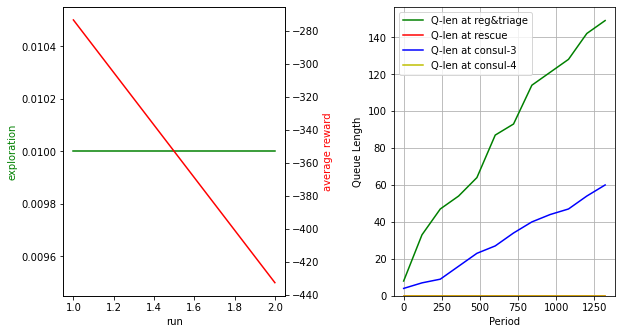

In [174]:
a = ed_management()